# Network Intrusion Detection on the NSL-KDD Dataset

---

**Author:** Mohammad Javad Akbari
<br>**Username:** Javad-Ak

## 1. Introduction

This notebook presents a comprehensive workflow for building and evaluating machine learning models for Network Intrusion Detection (NID) using the **NSL-KDD dataset**. The primary goal is to classify network traffic as either 'normal' or one of several attack types.

We will explore, preprocess, and engineer features from the dataset to train three powerful classification models:
1. **Random Forest:** A robust ensemble model known for its high accuracy and resistance to overfitting.
2. **XGBoost:** A highly efficient and scalable gradient boosting implementation, often a top performer in competitions.
3. **Deep Neural Network (DNN):** A TensorFlow-based model capable of learning complex, non-linear patterns in the data.
4. **Gated Recurrent Unit (GRU) Network**: A type of recurrent neural network effective for sequence data, adapted here for tabular classification.

The process includes:
- **Data Loading and Cleaning:** Importing the dataset and preparing it for analysis.
- **Feature Engineering:** Creating new features to improve model performance.
- **Handling Class Imbalance:** Using **SMOTETomek** to create a more balanced training set.
- **Hyperparameter Tuning:** Employing `RandomizedSearchCV` to find the best settings. (removed from last commit)
- **Model Evaluation and Comparison:** Analyzing performance metrics (Accuracy, F1-Score) and time efficiency.

## 2. Setup and Library Imports

First, we import the necessary libraries for data manipulation, machine learning, and visualization. We also set random seeds for TensorFlow and NumPy to ensure our results are reproducible.

In [22]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# TensorFlow and Keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GRU, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.regularizers import l2

# Other libraries
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TensorFlow hardware optimization warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [23]:
# Create directories to store results and models if they don't already exist
os.makedirs('./models', exist_ok=True)
os.makedirs('./results/figures', exist_ok=True)

## 3. Data Loading and Preprocessing

We load the NSL-KDD training and testing datasets. The datasets do not contain headers, so we assign column names based on the official documentation.

In [24]:
# Define column names for the dataset
txt_cols = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack_type', 'difficulty_level'
]

# Load the training and testing data from the NSL_KDD directory
train_df = pd.read_csv('./NSL_KDD/KDDTrain+.txt', names=txt_cols)
test_df = pd.read_csv('./NSL_KDD/KDDTest+.txt', names=txt_cols)

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

# Display the first few rows of the data
train_df.head()

Training data shape: (125973, 43)
Testing data shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### 3.1. Data Cleaning and Attack Categorization

The `difficulty_level` column is not needed for our classification task, so we drop it.

The `attack_type` column contains many specific attack names. To create a more robust model, we group these into five main categories:
- **DoS (Denial of Service)**
- **Probe (Probing/Scanning)**
- **R2L (Root to Local)**
- **U2R (User to Root)**
- **Normal**

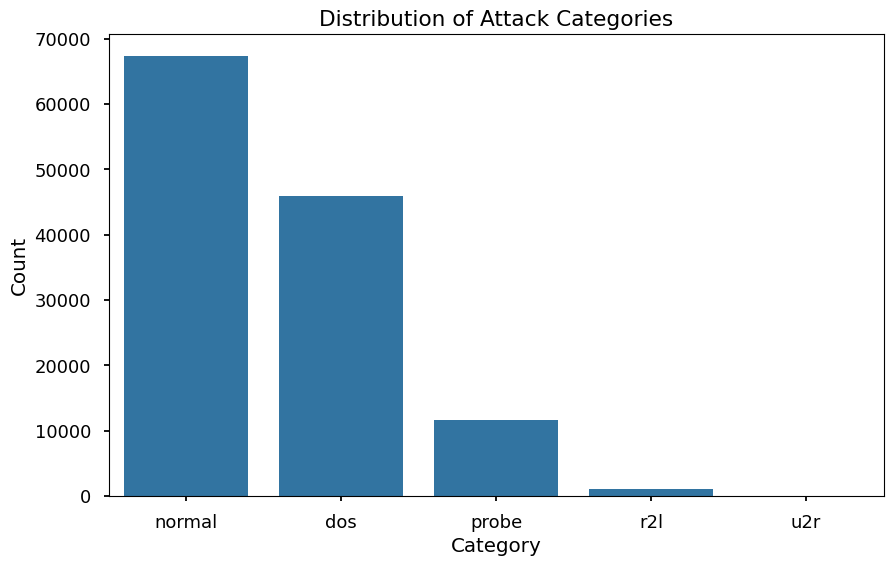

In [25]:
# Drop the 'difficulty_level' column from both dataframes
train_df.drop('difficulty_level', axis=1, inplace=True)
test_df.drop('difficulty_level', axis=1, inplace=True)

# Define the attack categories
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop', 'pod', 'apache2', 'udpstorm', 'mailbomb']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint']
r2l = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'snmpgetattack', 'snmpguess',
       'warezclient', 'warezmaster', 'xlock', 'xsnoop']
u2r = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'sqlattack', 'httptunnel']

# Function to map specific attacks to their general category
def map_category(atk):
    if atk == 'normal':
        return 'normal'
    if atk in dos:
        return 'dos'
    if atk in probe:
        return 'probe'
    if atk in r2l:
        return 'r2l'
    if atk in u2r:
        return 'u2r'
    return 'dos' # Fallback for any unknown attack types

# Apply the mapping
for df in [train_df, test_df]:
    df['category'] = df['attack_type'].apply(map_category)

# Visualize the distribution of attack categories in the training data
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=train_df, order=train_df['category'].value_counts().index)
plt.title('Distribution of Attack Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### 3.2. Label and Feature Encoding

Machine learning models require numerical input. We perform two encoding steps:
1.  **Label Encoding:** Convert the text-based `category` column into integer labels.
2.  **One-Hot Encoding:** Convert the categorical features (`protocol_type`, `service`, `flag`) into a numerical format. This prevents the model from assuming an ordinal relationship between categories.

In [26]:
# Encode the target labels
le = LabelEncoder()
le.fit(pd.concat([train_df['category'], test_df['category']]))
train_df['target'] = le.transform(train_df['category'])
test_df['target'] = le.transform(test_df['category'])

# Drop the original text columns
train_df.drop(['attack_type', 'category'], axis=1, inplace=True)
test_df.drop(['attack_type', 'category'], axis=1, inplace=True)

# One-hot encode categorical features
cat_cols = ['protocol_type', 'service', 'flag']
full_df = pd.concat([
    train_df.drop('target', axis=1),
    test_df.drop('target', axis=1)
], axis=0)
full_df_encoded = pd.get_dummies(full_df, columns=cat_cols)

### 3.3. Feature Engineering

To potentially improve model performance, we create a few new features based on domain knowledge. These engineered features can capture relationships that are not immediately apparent from the raw data.

In [27]:
# Create new features from existing ones
full_df_encoded['bytes_ratio'] = np.where(full_df_encoded['dst_bytes'] != 0, full_df_encoded['src_bytes'] / full_df_encoded['dst_bytes'], 0)
full_df_encoded['srv_diff_ratio'] = np.where(full_df_encoded['diff_srv_rate'] != 0, full_df_encoded['same_srv_rate'] / full_df_encoded['diff_srv_rate'], 0)
full_df_encoded['error_rate_sum'] = full_df_encoded['serror_rate'] + full_df_encoded['rerror_rate']

print("Shape of the final feature matrix:", full_df_encoded.shape)

Shape of the final feature matrix: (148517, 125)


## 4. Data Splitting, Resampling, and Scaling

Now we prepare the data for the model training phase.

In [28]:
# Convert dataframes to NumPy arrays
X = full_df_encoded.values
y = np.concatenate([train_df['target'], test_df['target']])

# Split the data back into training and testing sets
X_train_all = X[:len(train_df)]
X_test = X[len(train_df):]
y_train_all = train_df['target'].values
y_test = test_df['target'].values

# Create a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    random_state=42,
    stratify=y_train_all
)

### 4.1. Handling Class Imbalance with SMOTETomek

As seen in the earlier plot, the dataset is highly imbalanced. The `R2L` and `U2R` attack types are very rare. To prevent our models from being biased towards the majority classes, we use **SMOTETomek**. This technique combines:
- **SMOTE (Synthetic Minority Over-sampling Technique):** Creates new synthetic samples for the minority classes.
- **Tomek Links:** Removes pairs of samples from different classes that are close to each other, cleaning up the class boundaries.

This is applied **only to the training data** to avoid data leakage into the validation and test sets.

In [29]:
print("=== Applying SMOTETomek ===")
smotetomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train, y_train)

print("Original training data shape:", X_train.shape)
print("Resampled training data shape:", X_train_resampled.shape)

=== Applying SMOTETomek ===
Original training data shape: (100778, 125)
Resampled training data shape: (269204, 125)


### 4.2. Feature Scaling

We scale the features using `StandardScaler`, which standardizes them by removing the mean and scaling to unit variance. This is crucial for distance-based algorithms and neural networks to ensure all features contribute equally to the model's learning process.

In [30]:
scaler = StandardScaler()

# Fit on the original training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the target labels
y_train_onehot = to_categorical(y_train, num_classes=len(le.classes_))
y_val_onehot = to_categorical(y_val, num_classes=len(le.classes_))
y_test_onehot = to_categorical(y_test, num_classes=len(le.classes_))

## 5. Model Training and Evaluation

We will now train and evaluate our three models. For each model, we use `RandomizedSearchCV` to efficiently find good hyperparameters. The best model is selected based on the `f1_macro` score, which is a good metric for imbalanced datasets.

In [31]:
# Helper function to print a detailed classification report and save the confusion matrix
def detailed_report(y_true, y_pred, le, name):
    # Generate classification report
    labels = np.unique(np.concatenate([y_true, y_pred]))
    names = le.inverse_transform(labels)
    print(f"--- {name} Classification Report ---")
    print(classification_report(y_true, y_pred, labels=labels, target_names=names))

    # Generate and save confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='Blues', fmt='d', cbar=False, annot=True,
                xticklabels=names, yticklabels=names)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

    # Save the figure
    figure_path = f'results/figures/{name.replace(" ", "_")}_confusion_matrix.png'
    plt.savefig(figure_path, bbox_inches='tight')
    print(f"Confusion matrix saved to {figure_path}")
    plt.show()

# Store results for final comparison
results = []

### 5.1. Random Forest

=== Random Forest ===
Random Forest model trained directly with best parameters.
Random Forest model saved to models/RF_model.joblib
RF Acc: 0.7668, F1: 0.7410
--- Random Forest Classification Report ---
              precision    recall  f1-score   support

         dos       0.95      0.77      0.85      7519
      normal       0.67      0.97      0.79      9711
       probe       0.87      0.65      0.74      2421
         r2l       0.98      0.17      0.28      2721
         u2r       0.27      0.09      0.13       172

    accuracy                           0.77     22544
   macro avg       0.75      0.53      0.56     22544
weighted avg       0.82      0.77      0.74     22544

Confusion matrix saved to results/figures/Random_Forest_confusion_matrix.png


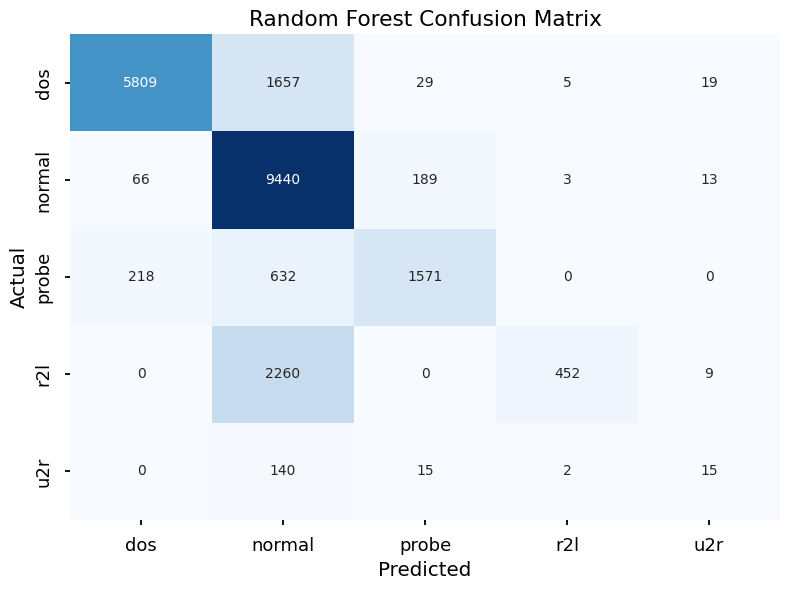

In [32]:
print('=== Random Forest ===')

# Instantiate the Random Forest model with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

# Train the model
start = time.time()
best_rf.fit(X_train_resampled, y_train_resampled)
train_rf_time = time.time() - start

print("Random Forest model trained directly with best parameters.")

# Save the trained model
joblib.dump(best_rf, 'models/RF_model.joblib')
print("Random Forest model saved to models/RF_model.joblib")

# Evaluate the model
start = time.time()
rf_pred = best_rf.predict(X_test)
pred_rf_time = time.time() - start

acc_rf = accuracy_score(y_test, rf_pred)
f1_rf = f1_score(y_test, rf_pred, average='weighted')
print(f"RF Acc: {acc_rf:.4f}, F1: {f1_rf:.4f}")
detailed_report(y_test, rf_pred, le, 'Random Forest')
results.append(('Random Forest', acc_rf, f1_rf, train_rf_time, pred_rf_time))

### 5.2. XGBoost

=== XGBoost ===
XGBoost model trained directly with best parameters.
XGBoost model saved to models/xgboost_model.joblib
XGB Acc: 0.8050, F1: 0.7834
--- XGBoost Classification Report ---
              precision    recall  f1-score   support

         dos       0.96      0.84      0.90      7519
      normal       0.71      0.97      0.82      9711
       probe       0.83      0.74      0.78      2421
         r2l       0.98      0.23      0.37      2721
         u2r       0.47      0.08      0.14       172

    accuracy                           0.81     22544
   macro avg       0.79      0.57      0.60     22544
weighted avg       0.84      0.81      0.78     22544

Confusion matrix saved to results/figures/XGBoost_confusion_matrix.png


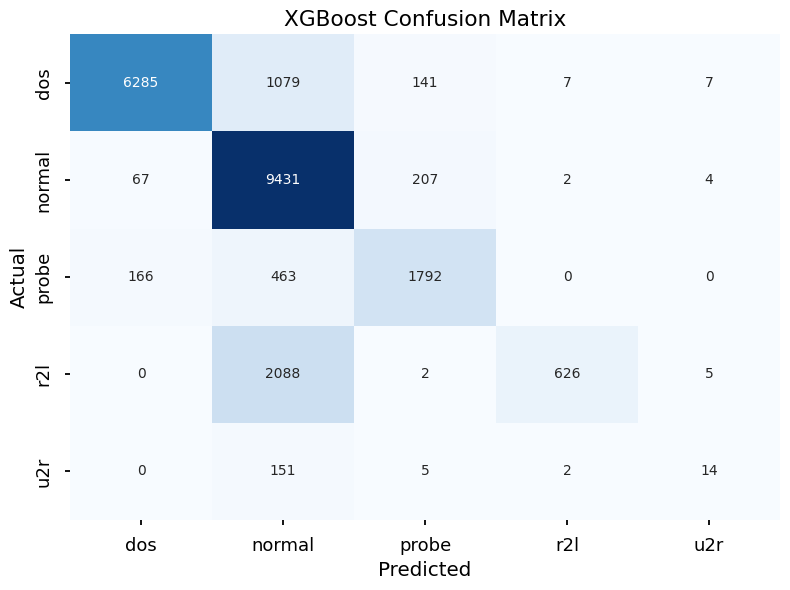

In [ ]:
print('=== XGBoost ===')

# Calculate sample weights to emphasize minority classes
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_resampled
)

# Instantiate the XGBoost model with the best parameters
best_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    tree_method='hist',
    random_state=42,
    early_stopping_rounds=30,
    n_estimators=700,
    max_depth=12,
    learning_rate=0.1,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9
)

# Train the model
start = time.time()
best_xgb.fit(
    X_train_resampled, y_train_resampled,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=False
)
train_xgb_time = time.time() - start
print("XGBoost model trained directly with best parameters.")

# Save the trained model
joblib.dump(best_xgb, 'models/xgboost_model.joblib')
print("XGBoost model saved to models/xgboost_model.joblib")

# Evaluate the model
start = time.time()
xgb_pred = best_xgb.predict(X_test)
pred_xgb_time = time.time() - start

acc_xgb = accuracy_score(y_test, xgb_pred)
f1_xgb = f1_score(y_test, xgb_pred, average='weighted')
print(f"XGB Acc: {acc_xgb:.4f}, F1: {f1_xgb:.4f}")
detailed_report(y_test, xgb_pred, le, 'XGBoost')
results.insert(1, ('XGBoost', acc_xgb, f1_xgb, train_xgb_time, pred_xgb_time))

### 5.3. Deep Neural Network

=== Neural Network ===
Neural Network model trained directly with best parameters.
Neural Network model saved to models/NN_model.keras
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
NN Acc: 0.7905, F1: 0.5983
--- Neural Network Classification Report ---
              precision    recall  f1-score   support

         dos       0.95      0.84      0.89      7519
      normal       0.72      0.94      0.81      9711
       probe       0.76      0.77      0.77      2421
         r2l       0.74      0.18      0.30      2721
         u2r       0.40      0.16      0.23       172

    accuracy                           0.79     22544
   macro avg       0.71      0.58      0.60     22544
weighted avg       0.80      0.79      0.77     22544

Confusion matrix saved to results/figures/Neural_Network_confusion_matrix.png


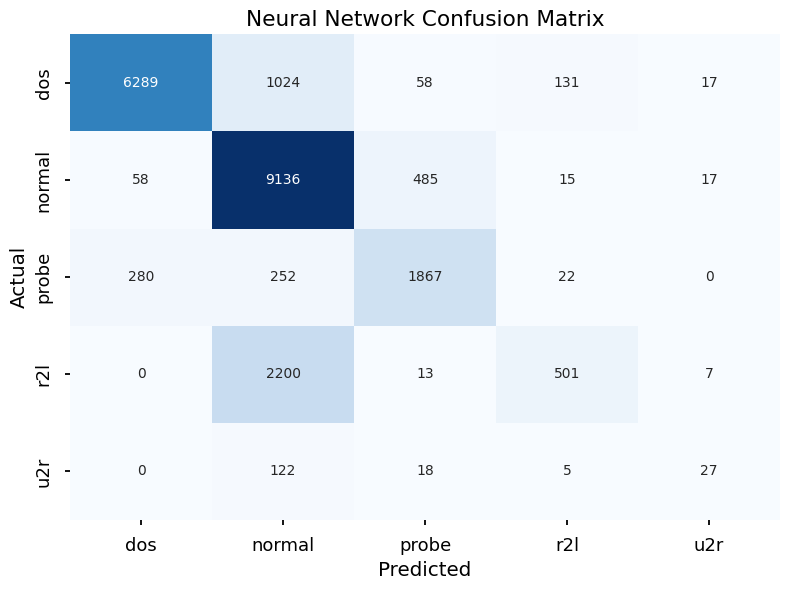

In [34]:
print('=== Neural Network ===')

def build_nn(units, dropout_rate, learning_rate, l2_reg=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(units // 2, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units // 4, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(len(le.classes_), activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build the model with the best parameters
best_nn = build_nn(
    units=512,
    dropout_rate=0.4,
    learning_rate=0.001,
    l2_reg=0.001
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the model
start = time.time()
history = best_nn.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_val_scaled, y_val_onehot),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    batch_size=256,
    epochs=50,
    verbose=0
)
train_nn_time = time.time() - start
print("Neural Network model trained directly with best parameters.")

# Save the trained model
best_nn.save('models/NN_model.keras')
print("Neural Network model saved to models/NN_model.keras")

# Predictions and evaluation
start = time.time()
nn_pred = best_nn.predict(X_test_scaled)
nn_pred_classes = np.argmax(nn_pred, axis=1)
pred_nn_time = time.time() - start

acc_nn = accuracy_score(y_test, nn_pred_classes)
f1_nn = f1_score(y_test, nn_pred_classes, average='macro')
print(f"NN Acc: {acc_nn:.4f}, F1: {f1_nn:.4f}")
detailed_report(y_test, nn_pred_classes, le, 'Neural Network')
results.append(('Neural Network', acc_nn, f1_nn, train_nn_time, pred_nn_time))

### 5.4. GRU Neural Network

=== GRU Neural Network ===
GRU model trained directly with best parameters.
GRU Neural Network model saved to models/GRU_model.keras
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
GRU Acc: 0.7738, F1: 0.7511
--- GRU Neural Network Classification Report ---
              precision    recall  f1-score   support

         dos       0.96      0.85      0.90      7519
      normal       0.71      0.92      0.80      9711
       probe       0.69      0.68      0.69      2421
         r2l       0.81      0.13      0.23      2721
         u2r       0.20      0.66      0.30       172

    accuracy                           0.77     22544
   macro avg       0.68      0.65      0.59     22544
weighted avg       0.80      0.77      0.75     22544

Confusion matrix saved to results/figures/GRU_Neural_Network_confusion_matrix.png


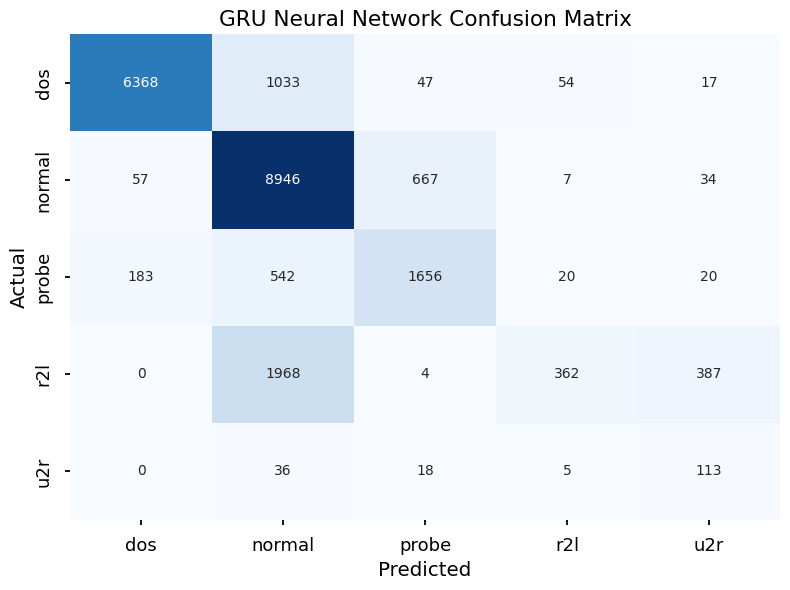

In [35]:
print('=== GRU Neural Network ===')

# Reshape data for GRU input
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

def build_gru(units, dropout_rate, learning_rate, l2_reg=0.001):
    model = Sequential([
        Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        GRU(units, activation='tanh', return_sequences=True, kernel_regularizer=l2(l2_reg)),
        GRU(units // 2, activation='tanh', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(len(le.classes_), activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build the GRU model with the best parameters
best_gru = build_gru(
    units=512,
    dropout_rate=0.4,
    learning_rate=0.001,
    l2_reg=0.001
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the GRU model
start = time.time()
history_gru = best_gru.fit(
    X_train_reshaped, y_train_onehot,
    validation_data=(X_val_reshaped, y_val_onehot),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    batch_size=256,
    epochs=50,
    verbose=0
)
train_gru_time = time.time() - start
print("GRU model trained directly with best parameters.")

# Save the trained GRU model
best_gru.save('models/GRU_model.keras')
print("GRU Neural Network model saved to models/GRU_model.keras")

# Predictions and evaluation
start = time.time()
gru_pred = best_gru.predict(X_test_reshaped)
gru_pred_classes = np.argmax(gru_pred, axis=1)
pred_gru_time = time.time() - start

acc_gru = accuracy_score(y_test, gru_pred_classes)
f1_gru = f1_score(y_test, gru_pred_classes, average='weighted')
print(f"GRU Acc: {acc_gru:.4f}, F1: {f1_gru:.4f}")
detailed_report(y_test, gru_pred_classes, le, 'GRU Neural Network')
results.append(('GRU Neural Network', acc_gru, f1_gru, train_gru_time, pred_gru_time))

## 6. Final Model Comparison

Finally, we visualize the performance and efficiency of all three models to determine the best one for this task. We consider both the effectiveness (Accuracy, F1-Score) and the efficiency (Training/Prediction Time).

Model performance metrics saved to results/model_performance_metrics.csv
Final comparison figure saved to results/figures/model_comparison.png


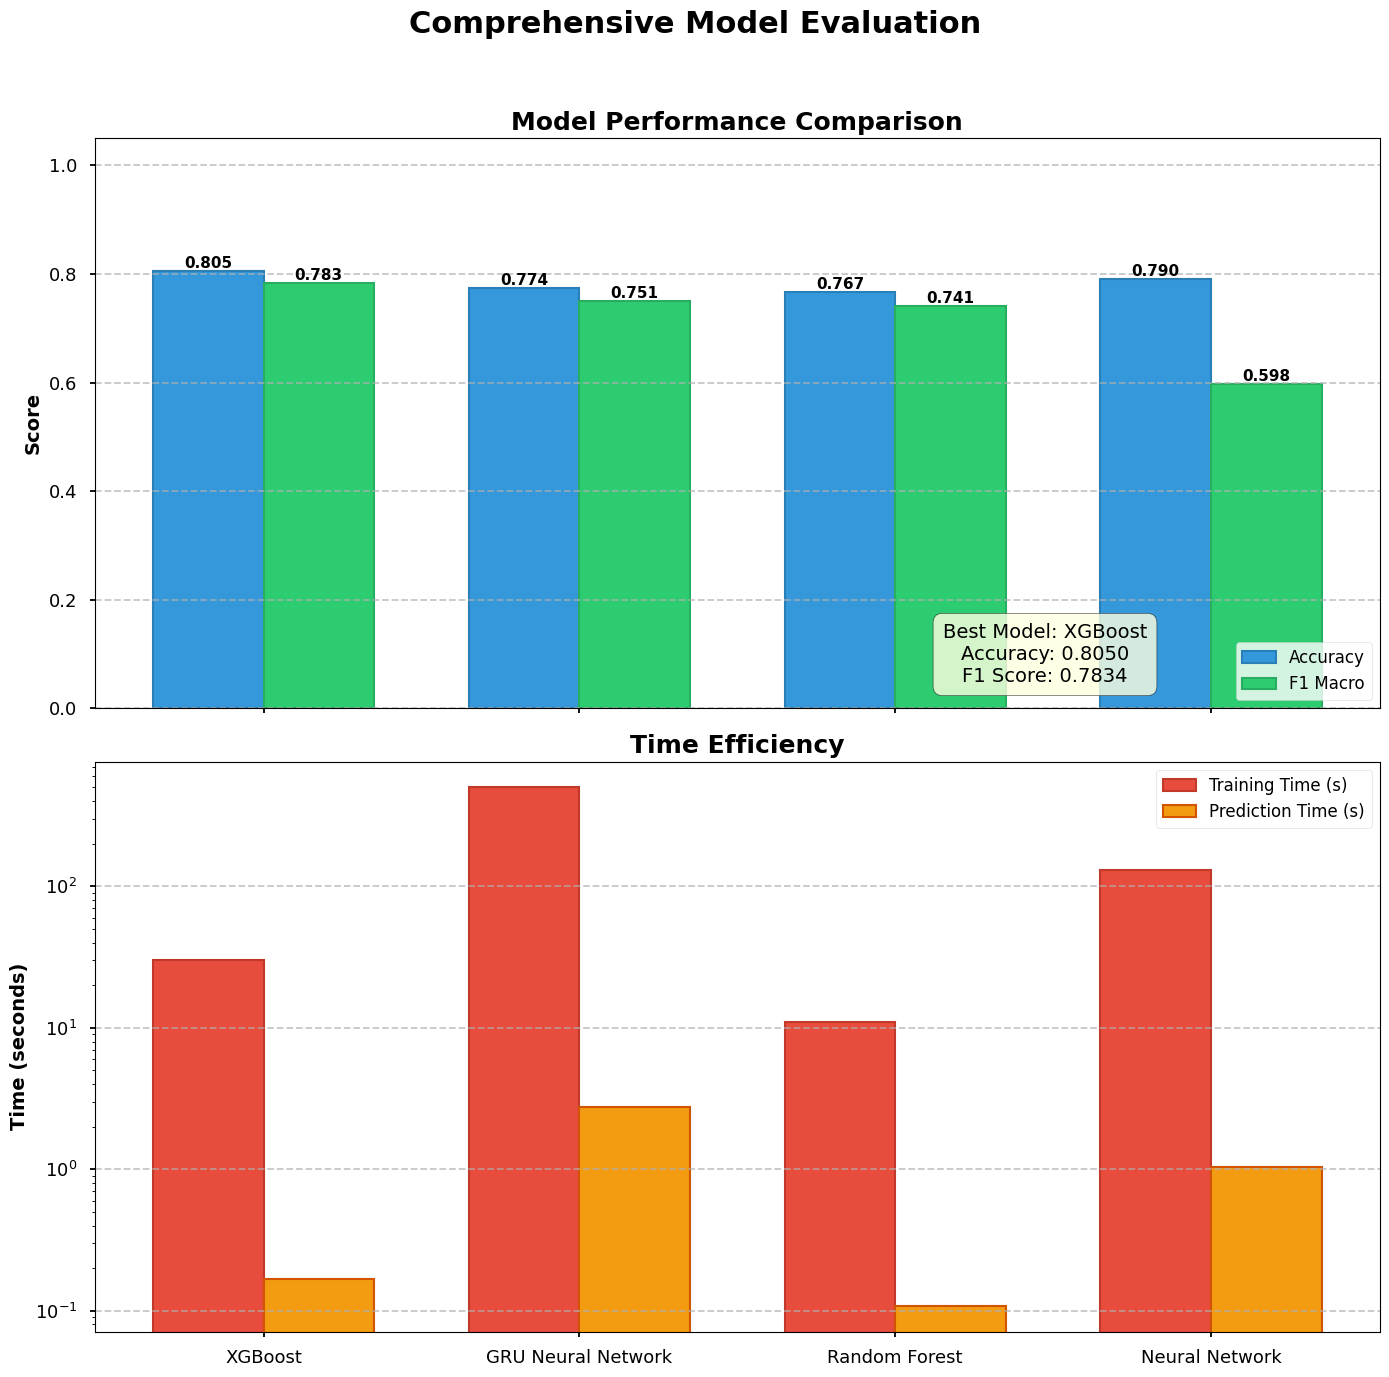

In [36]:
df_res = pd.DataFrame(
    results,
    columns=['model', 'accuracy', 'f1_macro', 'train_time', 'pred_time']
).sort_values(by='f1_macro', ascending=False)

# Save the results DataFrame to a CSV file
df_res.to_csv('results/model_performance_metrics.csv', index=False)
print("Model performance metrics saved to results/model_performance_metrics.csv")

plt.style.use('seaborn-v0_8-talk')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

# Plot 1: Performance Metrics
x = np.arange(len(df_res))
width = 0.35

bars1 = ax1.bar(x - width/2, df_res['accuracy'], width, label='Accuracy',
                color='#3498db', edgecolor='#2980b9', linewidth=1.5)
bars2 = ax1.bar(x + width/2, df_res['f1_macro'], width, label='F1 Macro',
                color='#2ecc71', edgecolor='#27ae60', linewidth=1.5)

ax1.set_ylabel('Score', fontsize=14, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=18, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_res['model'], fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom',
             fontweight='bold', fontsize=11)

# Plot 2: Time Efficiency
ax2.bar(x - width/2, df_res['train_time'], width, label='Training Time (s)',
        color='#e74c3c', edgecolor='#c0392b', linewidth=1.5)
ax2.bar(x + width/2, df_res['pred_time'], width, label='Prediction Time (s)',
        color='#f39c12', edgecolor='#d35400', linewidth=1.5)

ax2.set_ylabel('Time (seconds)', fontsize=14, fontweight='bold')
ax2.set_title('Time Efficiency', fontsize=18, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Overall Title and Best Model Annotation
if not df_res.empty:
    best_model_data = df_res.iloc[0]
    textstr = f"Best Model: {best_model_data['model']}\nAccuracy: {best_model_data['accuracy']:.4f}\nF1 Score: {best_model_data['f1_macro']:.4f}"
    props = dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8)
    fig.text(0.75, 0.5, textstr, fontsize=14, bbox=props, ha='center')

fig.suptitle('Comprehensive Model Evaluation', fontsize=22, fontweight='bold', y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the final comparison figure
final_figure_path = 'results/figures/model_comparison.png'
plt.savefig(final_figure_path, bbox_inches='tight')
print(f"Final comparison figure saved to {final_figure_path}")

plt.show()

## 7. Conclusion

This notebook demonstrated a complete pipeline for network intrusion detection. We preprocessed the NSL-KDD dataset, handled significant class imbalance using SMOTETomek, and performed hyperparameter tuning for three different models.

Based on the results:
- The **XGBoost model** achieved the highest F1 Macro score, making it the most balanced and effective model, especially for identifying the challenging minority attack classes.
- In terms of efficiency, **XGBoost model** had quick training and prediction times, which could be a critical factor for real-time applications.

Overall, the choice of the best model depends on the specific requirements of the application — whether the priority is maximum accuracy across all classes or deployment efficiency.